Reference = 'https://mccormickml.com/2019/07/22/BERT-fine-tuning/'

In [35]:
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#gpu 확인
device_name = tf.test.gpu_device_name()
print(device_name)
print("GPU Available: ", tf.test.is_gpu_available())

/device:GPU:0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True


In [12]:
# 네이버 영화리뷰 감정분석 데이터 다운로드
!git clone https://github.com/e9t/nsmc.git
    
train = pd.read_csv("nsmc/ratings_train.txt", sep='\t') #훈련
test = pd.read_csv("nsmc/ratings_test.txt", sep='\t') #테스트

In [13]:
#결측치제거
train.dropna(inplace=True)
test.dropna(inplace=True)

#중복제거
train.drop_duplicates(subset='document', inplace=True)
test.drop_duplicates(subset='document', inplace=True)

In [23]:
#Bert tokenizer에 맞게 형식 변환 - CLS = classification / SEP = seperation
train['document'] = train['document'].apply(lambda x: "[CLS] " + str(x) + " [SEP]")
test['document'] = test['document'].apply(lambda x: "[CLS] " + str(x) + " [SEP]")

'''
BERT tutorial에선
모든 sentence의 시작엔 CLS를, 끝엔 SEP를 붙여야 한다고 이야기하고 있다. 
이때 sentence의 단위를 문장의 단위로 보아야할까, 하나의 리뷰 단위로 보아야할까?
'''

# 훈련 데이터셋 전처리

In [62]:
sentences = train['document']
labels = train['label'].values

In [63]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

tokenized_texts[0]

'''
BERT는 형태소분석을 통해 토큰을 분리하지 않는다.
WordPiece를 사용, 한 단어 내에서 자주 나오는 글자들을 붙여 하나의 토큰으로 생성하기에 언어에 상관없이 토큰 생성 가능
신조어 같이 사전에 없는 단어를 처리하기에도 좋다.
'''

'\nBERT는 형태소분석을 통해 토큰을 분리하지 않는다.\nWordPiece를 사용, 한 단어 내에서 자주 나오는 글자들을 붙여 하나의 토큰으로 생성하기에 언어에 상관없이 토큰 생성 가능\n신조어 같이 사전에 없는 단어를 처리하기에도 좋다.\n'

문장의 최대 길이: 142


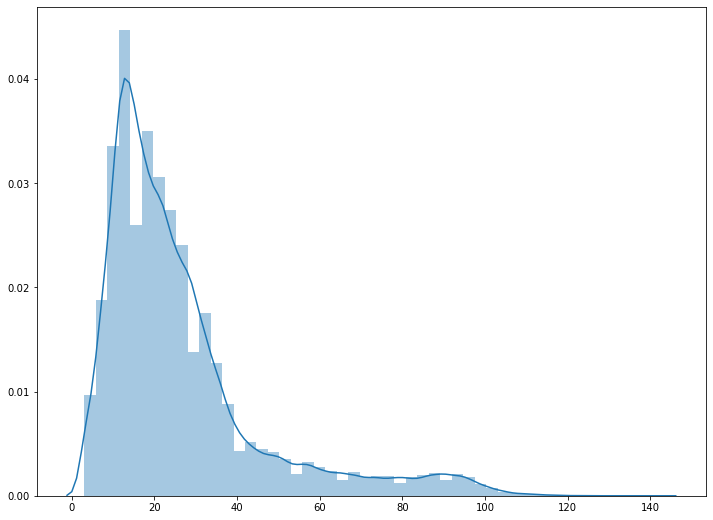

In [64]:
#토큰 문장 최대 길이 확인
maxlen = max(len(I) for I in tokenized_texts) 
print('문장의 최대 길이: {}'.format(maxlen))

count_len = pd.Series(tokenized_texts).apply(len)

plt.figure(figsize=(12,9))
sns.distplot(count_len)

BERT의 제약조건  
- 모든 문장은 padded나 truncated 되어야 하며, 단일하고 고정된 길이를 가져야함
- 최대 길이는 512

In [38]:
# 토큰 최대 길이 지정 - 분포에 따라 최대길이 조정하며 결과값을 비교하자
MAX_LEN = 128

# 토큰 정수 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 최대 길이에 맞춰 자르고 패딩 추가 - 패딩도 바꿀수 있지 않나? 
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

array([   101,   9519,   9074, 119005,    119,    119,   9708, 119235,
         9715, 119230,  16439,  77884,  48549,   9284,  22333,  12692,
          102,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [39]:
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 토큰이라면 1, 패딩이라면 0으로 설정 - 패딩은 어텐션 수행 X -> 속도향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
# # Tokenize all of the sentences and map the tokens to thier word IDs.
# input_ids = []
# attention_masks = []

# # For every sentence...
# for sent in sentences:
#     # `encode_plus` will:
#     #   (1) Tokenize the sentence.
#     #   (2) Prepend the `[CLS]` token to the start.
#     #   (3) Append the `[SEP]` token to the end.
#     #   (4) Map tokens to their IDs.
#     #   (5) Pad or truncate the sentence to `max_length`
#     #   (6) Create attention masks for [PAD] tokens.
#     encoded_dict = tokenizer.encode_plus(
#                         sent,                      # Sentence to encode.
#                         add_special_tokens = True, # Add '[CLS]' and '[SEP]'
#                         max_length = 64,           # Pad & truncate all sentences.
#                         pad_to_max_length = True,
#                         return_attention_mask = True,   # Construct attn. masks.
#                         return_tensors = 'pt',     # Return pytorch tensors.
#                    )
    
#     # Add the encoded sentence to the list.    
#     input_ids.append(encoded_dict['input_ids'])
    
#     # And its attention mask (simply differentiates padding from non-padding).
#     attention_masks.append(encoded_dict['attention_mask'])

# # Convert the lists into tensors.
# input_ids = torch.cat(input_ids, dim=0)
# attention_masks = torch.cat(attention_masks, dim=0)
# labels = torch.tensor(labels)

# # Print sentence 0, now as a list of IDs.
# print('Original: ', sentences[0])
# print('Token IDs:', input_ids[0])

In [43]:
# 훈련셋과 검증셋으로 분리
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels, 
                                                                                    random_state=2018, 
                                                                                    test_size=0.1)

# 어텐션 마스크를 훈련셋과 검증셋으로 분리
train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=2018, 
                                                       test_size=0.1)

# 데이터를 파이토치의 텐서로 변환
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [44]:
# 배치 사이즈 - 16, 32를 추천하고 있다.
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴, 즉 지금은 32개의 텐서씩 학습 - GPU 메모리와 관련
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data) #데이터 셔플을 위해 RandomSampler 사용 - 데이터로더는 index로 파일을 불러온다.
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# 테스트셋 전처리

In [53]:
sentences = test['document']

labels = test['label'].values
labels

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [54]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print (sentences[0])
print (tokenized_texts[0])

[CLS] 굳 ㅋ [SEP]
['[CLS]', '굳', '[UNK]', '[SEP]']


In [55]:
# 입력 토큰의 최대 시퀀스 길이
MAX_LEN = 128

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

array([ 101, 8911,  100,  102,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])

In [56]:
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [57]:
# 데이터를 파이토치의 텐서로 변환
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

print(test_inputs[0])
print(test_labels[0])
print(test_masks[0])

tensor([ 101, 8911,  100,  102,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0], dtype=torch.int32)
tensor(1)
tensor([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.

In [58]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# 모델 생성

튜토리얼에서 fine-tuning을 위해 추천하는 parameter

Batch size: 16, 32
Learning rate (Adam): 5e-5, 3e-5, 2e-5
Number of epochs: 2, 3, 4

In [59]:
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1660 Ti


In [60]:
# 분류를 위한 BERT 모델 생성
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2) #num_labels = 이진분류기에 2
model.cuda() #gpu 사용

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [65]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 4 #통상적으로 EPOCHS는 2-4 사이, 그 이상은 overfit의 위험이 존재

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 학습률을 조금씩 감소시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# 모델 학습

In [66]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [67]:
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        b_input_ids = torch.tensor(b_input_ids).to(device).long()

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = torch.tensor(b_input_ids).to(device).long()
        
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")

In [ ]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
dㅇ
# 그래디언트 초기화
model.zero_grad()
# gradient는 역전파 단계에서 자동으로 축적이 된다.


# 에폭만큼 반복
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        b_input_ids = torch.tensor(b_input_ids).to(device).long()

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

In [ ]:
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    b_input_ids = torch.tensor(b_input_ids).to(device).long()
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

# 새로운 문장 적용

In [ ]:
# 입력 데이터 변환
def convert_input_data(sentences):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

In [ ]:
# 문장 테스트
def test_sentences(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    b_input_ids = torch.tensor(b_input_ids).to(device).long()
        
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

In [ ]:
logits = test_sentences(['연기는 별로지만 재미 하나는 끝내줌!'])

# 모델 저장 & 불러오기

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


In [ ]:
Saving model to ./model_save/

('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')


In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
model = model_class.from_pretrained(output_dir)
tokenizer = tokenizer_class.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)